## 探索GradCAM++

In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import numpy as np
from torchsampler import ImbalancedDatasetSampler
from tqdm import tqdm

from gradcam import GradCAM, GradCAMpp, visualize_cam

In [3]:
TRAIN_DATASET_PATH = '../dataset/train_data'
IMG_SIZE = (512, 512)
BATCH_SIZE = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from senet import Baseline

model = Baseline(3094,
                 1,
                 '~/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth',
                 # 重要! ImageNet预训练权重下载地址为http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth
                 'bnneck',
                 'after',
                 'se_resnext50',
                 'imagenet',
                 no_feat=True
                )

model.load_state_dict(torch.load('../model/se_resnext50_512_best_trick.pth'))
model.eval(), model.to(device)
print()

Loading pretrained ImageNet model......



In [4]:
def custom_callback_get_label(_dataset, _idx):
    return _dataset[_idx][1]

class PadResize(object):
    def __init__(self,size):
        self.interpolation = Image.BILINEAR
        self.padding_v = [124, 116, 104]
        self.size = size
    def __call__(self, img):
        target_size = self.size
        padding_v = tuple(self.padding_v)
        interpolation = self.interpolation
        w, h = img.size
        if w > h:
            img = img.resize((int(target_size), int(h * target_size * 1.0 / w)), interpolation)
        else:
            img = img.resize((int(w * target_size * 1.0 / h), int(target_size)), interpolation)

        ret_img = Image.new("RGB", (target_size, target_size), padding_v)
        w, h = img.size
        st_w = int((ret_img.size[0] - w) / 2.0)
        st_h = int((ret_img.size[1] - h) / 2.0)
        ret_img.paste(img, (st_w, st_h))
        return ret_img


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_fns, label_dict, data_transforms):
        self.image_fns = image_fns
        self.label_dict= label_dict
        self.transforms = data_transforms
    
    def __getitem__(self, index):
        label = self.label_dict[self.image_fns[index].split('/')[-2]]
        image = Image.open(self.image_fns[index]).convert("RGB")
        image = self.transforms(image)
        norm_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
        
        return image, norm_image, self.image_fns[index], label#, image_fns[index]
    
    def __len__(self):
        return len(self.image_fns)
    

        
image_fns = glob(os.path.join(TRAIN_DATASET_PATH, '*', '*.*'))
label_names = [s.split('/')[-2] for s in image_fns]
unique_labels = list(set(label_names))
unique_labels.sort()
id_labels = {_id:name for name, _id in enumerate(unique_labels)}

NUM_CLASSES = len(unique_labels)
print("NUM_CLASSES:", NUM_CLASSES)

# train_transform = transforms.Compose([
#      transforms.RandomRotation((-30, 30)),
# #      transforms.RandomRotation(90),
# #      transforms.RandomRotation(-90),
#      PadResize(IMG_SIZE[0]),
# #      transforms.Scale(IMG_SIZE[0]),
# #      transforms.CenterCrop(IMG_SIZE[0]),
#      transforms.ColorJitter(brightness=1, contrast=0.5,saturation=1),
#      transforms.ToTensor(),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

transform = transforms.Compose([
#     [transforms.Scale(IMG_SIZE[0]),
#      transforms.CenterCrop(IMG_SIZE[0]),
     PadResize(IMG_SIZE[0]),
     transforms.ToTensor()])




dataset = ImageDataset(image_fns, id_labels, transform)
loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True, 
                                           num_workers=20)



NUM_CLASSES: 3094


In [24]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_fns, data_transforms):
        self.image_fns = image_fns
        self.transforms = data_transforms
    
    def __getitem__(self, index):
        fp = self.image_fns[index]
        fn = os.path.basename(fp)
        image = Image.open(fp).convert("RGB")
        
        
        # Preprocessing
        image = self.transforms(image)
        norm_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
        
        return image, norm_image, 0, 0#, image_fns[index]
        
        return image, fn
    
    def __len__(self):
        return len(self.image_fns)

TEST_DATASET_PATH = '../dataset/test_data_A/'
gallery_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'gallery', '*.*'))
print(gallery_image_fns[:10])
query_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'query', '*.*'))

test_transform = transforms.Compose([
#      transforms.CenterCrop(IMG_SIZE[0]),
     PadResize(IMG_SIZE[0]),
     transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

gallery_dataset = TestImageDataset(gallery_image_fns, test_transform)
gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=20)

query_dataset = TestImageDataset(query_image_fns, test_transform)
query_loader = torch.utils.data.DataLoader(query_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=20)

['../dataset/test_data_A/gallery/UHZ5JYLDWF714K20.jpg', '../dataset/test_data_A/gallery/WOP4MLRAJGVD0F7H.jpg', '../dataset/test_data_A/gallery/65TWSBYN9UFJGIRD.jpg', '../dataset/test_data_A/gallery/PEGSBYA1D4NOF05R.jpg', '../dataset/test_data_A/gallery/M94QCBWYVS8DP652.jpg', '../dataset/test_data_A/gallery/7NHLEDQ6JG5K42A0.jpg', '../dataset/test_data_A/gallery/TDWIR4XO2BN8H1Z3.jpg', '../dataset/test_data_A/gallery/FD1GQ860JASWP4HI.jpg', '../dataset/test_data_A/gallery/XLVH2FKCAUJTP0M8.jpg', '../dataset/test_data_A/gallery/GZIFASPNROQ3B6K1.jpg']


In [25]:
cam_dict = dict()

seresnext_model_dict = dict(type='seresnext', arch=model, layer_name='layer4', input_size=IMG_SIZE)
seresnext_gradcam = GradCAM(seresnext_model_dict, True)
seresnext_gradcampp = GradCAMpp(seresnext_model_dict, True)
cam_dict['seresnext'] = [seresnext_gradcam, seresnext_gradcampp]

saliency_map size : torch.Size([32, 32])
saliency_map size : torch.Size([32, 32])


  0%|          | 0/9600 [00:00<?, ?it/s]

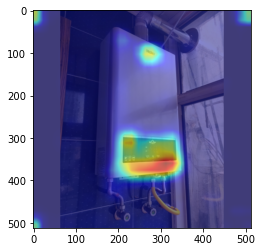

  0%|          | 0/9600 [00:00<?, ?it/s]


In [127]:
import matplotlib.pyplot as plt
SAVE_DATASET_PATH = '../salient_dataset/train_data'
def hard_apply_cam(mask, img):

    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().cpu().numpy()), cv2.COLORMAP_JET)
    grayscaled = cv2.cvtColor(heatmap,cv2.COLOR_BGR2GRAY)
    retval, heatmap = cv2.threshold(grayscaled, 40, 255, cv2.THRESH_BINARY)
    heatmap = np.stack([heatmap,]*3, axis=-1)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap*img.cpu()
    result = result.div(result.max()).squeeze()
    
    return heatmap, result

for inputs, norm_imputs, fns, labels in tqdm(query_loader):
    inputs = inputs.to(device)
    norm_inputs = norm_imputs.to(device)
    labels = labels.to(device)
    mask_pp, _ = seresnext_gradcampp(norm_inputs)
# Soft Mask
    heatmap_pp, result_pp = visualize_cam(mask_pp, inputs)

# Hard Mask
#     heatmap_pp, result_pp = hard_apply_cam(mask_pp, inputs)
    
    plt.imshow(result_pp.permute(1,2,0).cpu().numpy())
    plt.show()
    break
    
#     save_fn = fns[0].replace('dataset', 'salient_dataset')
#     save_dir = os.path.join(SAVE_DATASET_PATH, save_fn.split('/')[-2])
#     if os.path.exists(save_dir) is not True:
#         os.mkdir(save_dir)
        
#     plt.imsave(save_fn, result_pp.permute(1,2,0).cpu().numpy())
    
    